In [15]:
!uv pip install kagglehub

Using Python 3.11.6 environment at: /Users/nyeinchan/Desktop/time-series/.venv
Audited 1 package in 16ms


In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsforecast import StatsForecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series

from window_ops.rolling import rolling_mean, rolling_std

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [18]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  str    
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), str(1)
memory usage: 2.2 MB


In [19]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.head(10)

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
5,2011-01-01 06:00:00,8711.0
6,2011-01-01 07:00:00,8943.0
7,2011-01-01 08:00:00,9222.0
8,2011-01-01 09:00:00,9430.0
9,2011-01-01 10:00:00,9670.0


In [20]:
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'
df = df[['unique_id', 'ds', 'y']]

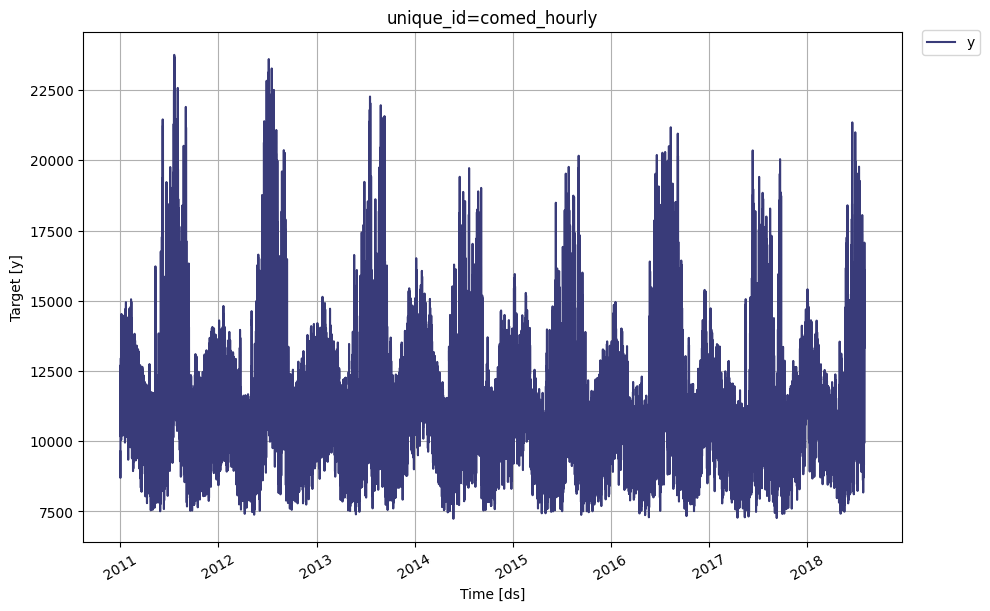

In [21]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


Handle DST issues just like in stats notebook

In [22]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


In [23]:
dst_times = [
    "2014-11-02 02:00:00",
    "2015-11-01 02:00:00",
    "2016-11-06 02:00:00",
    "2017-11-05 02:00:00",
]

for t in dst_times:
    t = pd.Timestamp(t)

    rows = df[df['ds'] == t]

    combined_y = rows['y'].sum() / 2

    # keep the first row
    keep_idx = rows.index[0]
    drop_idx = rows.index[1]

    df.loc[keep_idx, 'y'] = combined_y
    df = df.drop(drop_idx)


full_range = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='h')})

df = full_range.merge(df, on='ds', how='left')
df['unique_id'] = df['unique_id'].ffill()

df['y'] = df['y'].interpolate(method='linear')

In [24]:
len(df)

66504

### Feature Engineering

Since comparing baseline methods with statistical methods.\
SeasonalNaive_Daily is has the highest accruacy and it means\
Today at 3pm ~= Yesterday at 3pm

`residual_24_hour = y_t - y_t-24`

Also weekly pattern

`residual_168_hour = y_t - y_t-168`

Also pattern deviation weekly

`residual_168_24 = (y_t - y_t-24) - (y_t-168 - y_t-192)`

<br>

List of features that will be added
- Lag features
- Rolling statistics 24, 168
- Calendar Features
- Fourier terms - optional

In [25]:
# calendar features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.day_of_week
df['month'] = df['ds'].dt.month
df['is_weekend'] = (df['ds'].dt.day_of_week >= 5).astype(int)

cal = USFederalHolidayCalendar()
us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
ds_norm = df['ds'].dt.normalize()

df['is_holiday'] = ds_norm.isin(us_holidays).astype(int)
df['is_day_before_holiday'] = ds_norm.isin(us_holidays - pd.Timedelta(days=1)).astype(int)
df['is_day_after_holiday']  = ds_norm.isin(us_holidays + pd.Timedelta(days=1)).astype(int)

In [26]:
# fourier harmonics for annual cycle
day_of_year = df['ds'].dt.dayofyear
for k in range(1, 4):
    # k=3 cycles per year
    df[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
    df[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

In [27]:
# drop nan-values from first shifts
df_clean = df.dropna().reset_index(drop=True)

test_size = 24 * 14
train_ml = df_clean.iloc[:-test_size]
test_ml  = df_clean.iloc[-test_size:]

In [28]:
exogeneous_features = [
    'hour', 'dayofweek', 'month', 'is_weekend',
    'is_holiday', 'is_day_before_holiday', 'is_day_after_holiday',
    'sin_annual_1', 'cos_annual_1',
    'sin_annual_2', 'cos_annual_2',
    'sin_annual_3', 'cos_annual_3',
]

mlf = MLForecast(
    models={
        'xgboost': XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        24: [(rolling_mean, 24), (rolling_std, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168)],
    },
)

mlf.fit(train_ml[['unique_id', 'ds', 'y'] + exogeneous_features], static_features=[])

# predict
future_exog = test_ml[['unique_id', 'ds'] + exogeneous_features]
preds = mlf.predict(h=336, X_df=future_exog)

preds

,unique_id,ds,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12547.457031,12663.953978,12669.835417
1,comed_hourly,2018-07-20 02:00:00,11639.398438,11818.710669,11874.541652
2,comed_hourly,2018-07-20 03:00:00,10998.833984,11167.314204,11274.552801
3,comed_hourly,2018-07-20 04:00:00,10563.253906,10687.156630,10819.363568
4,comed_hourly,2018-07-20 05:00:00,10325.378906,10399.052590,10544.495880
...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,14668.266602,13890.109348,15202.539015
332,comed_hourly,2018-08-02 21:00:00,14194.610352,13612.117570,14803.834027
333,comed_hourly,2018-08-02 22:00:00,13840.912109,13390.664849,14419.432704
334,comed_hourly,2018-08-02 23:00:00,13387.727539,13043.121420,14022.917475


In [30]:
cv_ml = mlf.cross_validation(
    df=train_ml[['unique_id', 'ds', 'y'] + exogeneous_features],
    h=336,
    n_windows=5,
    step_size=336,
    static_features=[]
)

cross-validation

In [31]:
eval_ml = evaluate(
    cv_ml,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

eval_ml

,unique_id,cutoff,metric,xgboost,catboost,lgbm
0,comed_hourly,2018-05-11,mae,512.253523,711.335808,527.689080
1,comed_hourly,2018-05-25,mae,1861.671372,1820.559541,1886.283341
2,comed_hourly,2018-06-08,mae,1758.453770,1841.933435,1667.018823
3,comed_hourly,2018-06-22,mae,2001.935259,2422.148673,1941.434288
4,comed_hourly,2018-07-06,mae,1499.782567,1827.037228,1465.814366
5,comed_hourly,2018-05-11,rmse,642.084334,875.386906,692.152438
6,comed_hourly,2018-05-25,rmse,2546.810145,2463.077683,2542.180700
7,comed_hourly,2018-06-08,rmse,2697.134843,2677.324547,2493.291496
8,comed_hourly,2018-06-22,rmse,2642.326580,3158.476582,2602.845430
9,comed_hourly,2018-07-06,rmse,1818.839535,2304.308016,1823.901716


In [32]:
eval_ml[eval_ml['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

lgbm        2030.874356
xgboost     2069.439087
catboost    2295.714747
dtype: float64

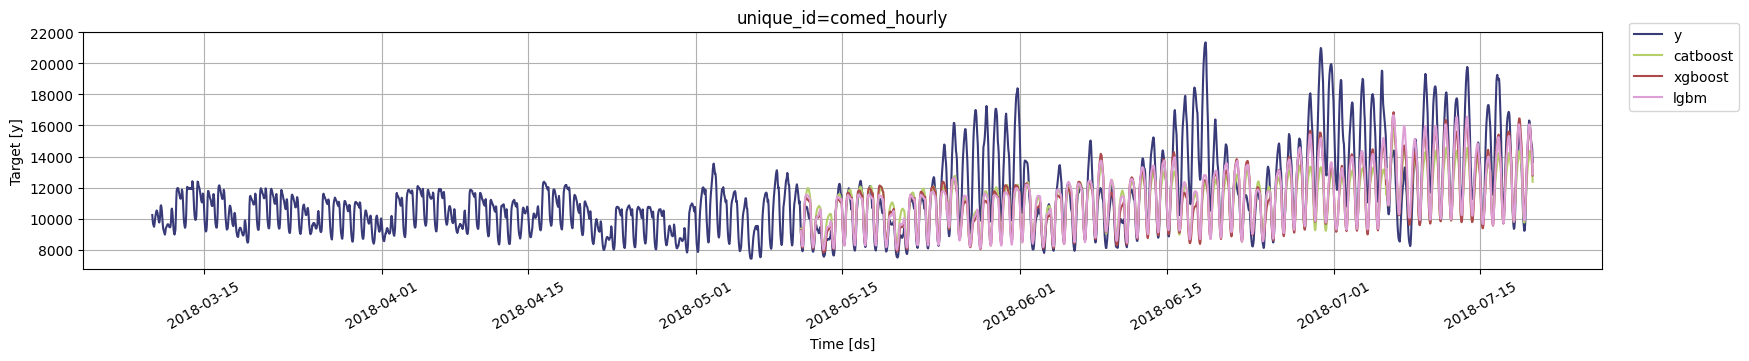

In [37]:
# comparing across 5 folds
StatsForecast.plot(
    train_ml[63000:],
    cv_ml[
        [
            'unique_id', 'ds', 
            'catboost',
            'xgboost',
            'lgbm',
        ]
    ]
)

- summer spikes are harder to predict even for tree-based models
- adding weather | temperature features might improve a bit

Evaluation on splitted test set\
14 days | 336 hours

In [34]:
# merge predictions with actual test values
eval_df = test_ml[['unique_id', 'ds', 'y']].merge(
    preds,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df

,unique_id,ds,y,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12682.0,12547.457031,12663.953978,12669.835417
1,comed_hourly,2018-07-20 02:00:00,11929.0,11639.398438,11818.710669,11874.541652
2,comed_hourly,2018-07-20 03:00:00,11327.0,10998.833984,11167.314204,11274.552801
3,comed_hourly,2018-07-20 04:00:00,10895.0,10563.253906,10687.156630,10819.363568
4,comed_hourly,2018-07-20 05:00:00,10676.0,10325.378906,10399.052590,10544.495880
...,...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,16437.0,14668.266602,13890.109348,15202.539015
332,comed_hourly,2018-08-02 21:00:00,15590.0,14194.610352,13612.117570,14803.834027
333,comed_hourly,2018-08-02 22:00:00,15086.0,13840.912109,13390.664849,14419.432704
334,comed_hourly,2018-08-02 23:00:00,14448.0,13387.727539,13043.121420,14022.917475


In [35]:
final_eval_ml = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

final_eval_ml

,unique_id,metric,xgboost,catboost,lgbm
0,comed_hourly,mae,919.410028,1099.570154,903.410736
1,comed_hourly,rmse,1110.958938,1330.281347,1106.956995


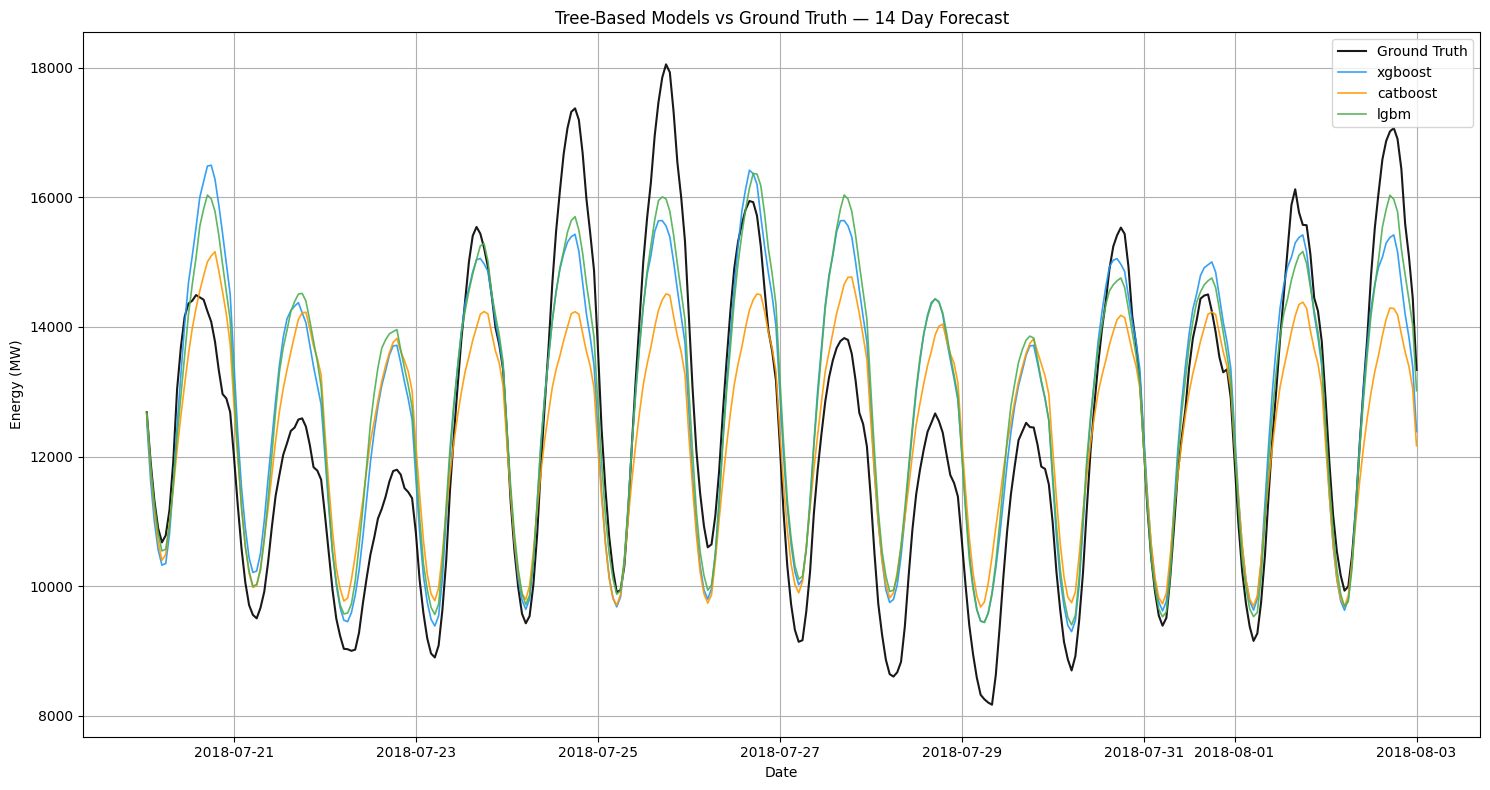

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(eval_df['ds'], eval_df['y'], label='Ground Truth', color='black', linewidth=1.5, alpha=0.9)

colors = {'xgboost': '#2196F3', 'catboost': '#FF9800', 'lgbm': '#4CAF50'}
for model, color in colors.items():
    ax.plot(eval_df['ds'], eval_df[model], label=f'{model}', color=color, linewidth=1.2, linestyle='-', alpha=0.9)

ax.set_title('Tree-Based Models vs Ground Truth — 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

Actual Inference 2weeks

In [67]:
mlf_final = MLForecast(
    models={
        'xgboost' : XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        'lgbm'    : LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        24:  [(rolling_mean, 24),  (rolling_std, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168)],
    },
)

mlf_final.fit(
    df_clean[['unique_id', 'ds', 'y'] + exogeneous_features],
    static_features=[]
)

MLForecast(models=[xgboost, catboost, lgbm], freq=h, lag_features=['lag1', 'lag2', 'lag24', 'lag48', 'lag168', 'lag336', 'rolling_mean_lag24_window_size24', 'rolling_std_lag24_window_size24', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168'], date_features=[], num_threads=1)

In [68]:
# build future featu

last_ds     = df_clean['ds'].max()
future_ds   = pd.date_range(start=last_ds + pd.Timedelta(hours=1), periods=336, freq='h')
future_exog = pd.DataFrame({'unique_id': 'comed_hourly', 'ds': future_ds})

future_exog['hour']       = future_exog['ds'].dt.hour
future_exog['dayofweek']  = future_exog['ds'].dt.dayofweek
future_exog['month']      = future_exog['ds'].dt.month
future_exog['is_weekend'] = (future_exog['dayofweek'] >= 5).astype(int)

us_holidays_future = cal.holidays(start=future_exog['ds'].min(), end=future_exog['ds'].max())
ds_norm_future     = future_exog['ds'].dt.normalize()
future_exog['is_holiday']            = ds_norm_future.isin(us_holidays_future).astype(int)
future_exog['is_day_before_holiday'] = ds_norm_future.isin(us_holidays_future - pd.Timedelta(days=1)).astype(int)
future_exog['is_day_after_holiday']  = ds_norm_future.isin(us_holidays_future + pd.Timedelta(days=1)).astype(int)

doy = future_exog['ds'].dt.dayofyear
for k in range(1, 4):
    future_exog[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * doy / 365.25)
    future_exog[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * doy / 365.25)

In [69]:
future_preds = mlf_final.predict(
    h=336,
    X_df=future_exog[['unique_id', 'ds'] + exogeneous_features]
)

future_preds

,unique_id,ds,xgboost,catboost,lgbm
0,comed_hourly,2018-08-03 01:00:00,12283.253906,12401.937764,12287.334930
1,comed_hourly,2018-08-03 02:00:00,11464.401367,11556.929423,11382.951465
2,comed_hourly,2018-08-03 03:00:00,10842.981445,10903.455572,10799.480225
3,comed_hourly,2018-08-03 04:00:00,10376.003906,10433.176149,10363.903600
4,comed_hourly,2018-08-03 05:00:00,10213.039062,10229.085094,10149.128997
...,...,...,...,...,...
331,comed_hourly,2018-08-16 20:00:00,13444.732422,13131.533034,13637.739341
332,comed_hourly,2018-08-16 21:00:00,13137.735352,12970.588820,13317.293108
333,comed_hourly,2018-08-16 22:00:00,12850.613281,12806.055753,13023.317434
334,comed_hourly,2018-08-16 23:00:00,12365.733398,12471.899145,12604.649193


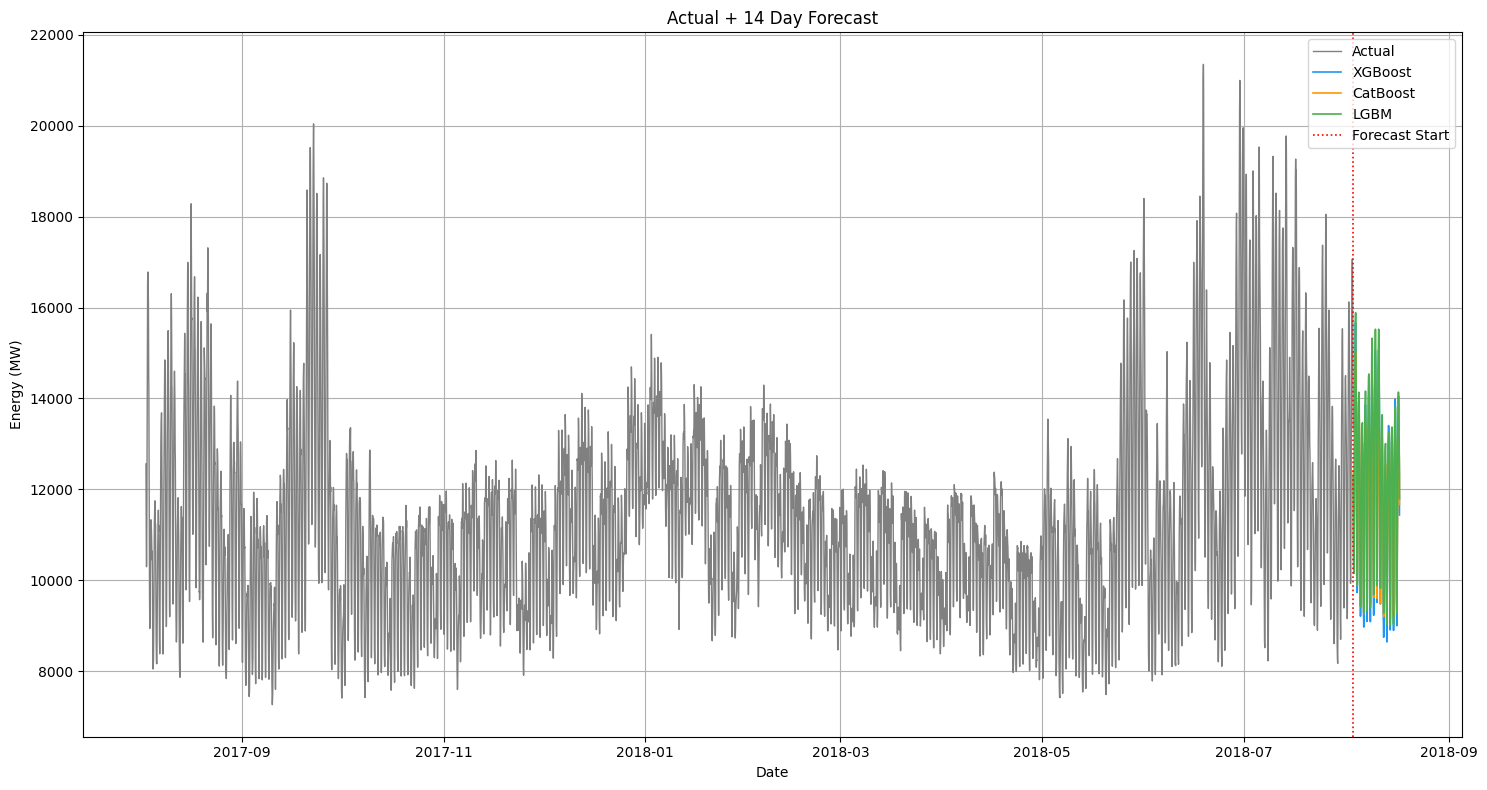

In [73]:
fig, ax = plt.subplots(figsize=(15, 8))

# last 1 year of
context = df_clean.iloc[-24*365:]

ax.plot(context['ds'], context['y'], color='gray', linewidth=1, label='Actual')
ax.plot(future_preds['ds'], future_preds['xgboost'],  color='#2196F3', linewidth=1.2, linestyle='-', label='XGBoost')
ax.plot(future_preds['ds'], future_preds['catboost'], color='#FF9800', linewidth=1.2, linestyle='-', label='CatBoost')
ax.plot(future_preds['ds'], future_preds['lgbm'],     color='#4CAF50', linewidth=1.2, linestyle='-', label='LGBM')

ax.axvline(x=df_clean['ds'].max(), color='red', linestyle=':', linewidth=1.2, label='Forecast Start')
ax.set_title('Actual + 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()